# CamVid

* UNet with MobileNetV2 & EfficientNet as encoder, with symmetrical decoder.
* Effect of bayesian inference

# Install & Import

In [1]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
import copy
import random
import json
import math
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial
from datetime import date
from prettytable import PrettyTable
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim, Tensor, ones_like, zeros_like
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import torchvision
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from torchvision.datasets import VOCSegmentation
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchsummary import summary

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union
# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cpu


# Archived

### Pascal VOC 2012

Training set: 1464

Validation set: 1449

Testing set is not available and only evaluated through submission

In [ ]:
# if 'data' not in os.listdir('/content/'):
#   !mkdir '/content/data/'
#   !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/VOCtrainval_11-May-2012.tar' '/content/data/'

# download_dataset = 'VOCdevkit' not in os.listdir('/content/data/')

# train_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="train",
#                                                      download=download_dataset)

# val_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="val",
#                                                      download=download_dataset)

# # test_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
# #                                                      year="2007",
# #                                                      image_set="test",
# #                                                      download=download_dataset)

# print(f'Training set length: {train_dataset}')
# print(f'Validation set length: {val_dataset}')
# # print(f'Test set length: {test_dataset}')

In [ ]:
# Global variables (PASCAL VOC 2012)
# CLASSES = [
#   "background",
#   "aeroplane",
#   "bicycle",
#   "bird",
#   "boat",
#   "bottle",
#   "bus",
#   "car",
#   "cat",
#   "chair",
#   "cow",
#   "diningtable",
#   "dog",
#   "horse",
#   "motorbike",
#   "person",
#   "pottedplant",
#   "sheep",
#   "sofa",
#   "train",
#   "tvmonitor",
# ]

# # dummy pixel (placed at boundaries)
# DROP_PIX = 255
# FILL_PIX = 21

# CLASS_MAP_ALL = {i: v for (i, v) in enumerate(CLASSES)}
# CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
# CLASS_MAP_ALL[FILL_PIX] = 'ambiguous'

# NUM_CLASSES = len(CLASS_MAP.keys())
# SEED = 0


In [ ]:
# METHODS FOR PASCAL
def load_pascal_into_memory(dataset:Dataset, t)->MemoryDataset:
    n = len(dataset)
    # preallocate tensor memory
    X = torch.zeros((n, 3, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((256, 256), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST, antialias=False)

    for i in tqdm(range(n)):
      x, y = dataset[i]

      x = to_tensor(x).to(torch.float).to(DEVICE)
      y = to_tensor(y).to(torch.float).to(DEVICE)

      x = resize_x(x)
      y = resize_y(y)

      x = x / 255.0
      y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)


def get_pascal_train_dataset(transforms) -> Dataset:
    download_dataset = 'data' not in os.listdir('/content/')

    train_dataset = VOCSegmentation(root="/content/data",
                                    year="2012",
                                    image_set="train",
                                    download=download_dataset)
    return load_pascal_into_memory(train_dataset, transforms)

def get_pascal_val_dataset(transforms) -> Dataset:
    download_dataset = 'data' not in os.listdir('/content/')

    val_dataset = VOCSegmentation(root="/content/data",
                                  year="2012",
                                  image_set="val",
                                  download=download_dataset)
    return load_pascal_into_memory(val_dataset, transforms)

### Cityscapes

Has to be loaded from google drive - dataset is 11GB

Abandoned because image resolution is too high & not a practical scope

In [ ]:
# !mkdir '/content/data'
# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/leftImg8bit_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/leftImg8bit_trainvaltest.zip'

# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/gtFine_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/gtFine_trainvaltest.zip'

# train_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                                 split='train',
#                                                 mode='fine',
#                                                 target_type='semantic')


# val_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='val',
#                                               mode='fine',
#                                               target_type='semantic')

# test_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='test',
#                                               mode='fine',
#                                               target_type='semantic')


# print(f'Train dataset: {len(train_dataset)}')
# print(f'Val dataset: {len(val_dataset)}')
# print(f'Test dataset: {len(test_dataset)}')

# split = val_dataset

# id = np.random.randint(1, len(split))

# plt.figure(figsize=(8, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(split[id][0])
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(split[id][1])
# plt.axis('off')

# Datasets



In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


### CamVid

In [4]:
if 'CamVid' not in os.listdir('/content'):
  !mkdir '/content/data'
  !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/camvid.zip' '/content/data/'
  !unzip -q '/content/data/camvid.zip'

## Define some Global Variables

In [5]:
# get classes for CamVid

# class_dict = pd.read_csv('/content/CamVid/class_dict.csv')

RGB2CLSNAME = {
    (128, 128, 128): "Sky",

    (0, 128, 64): "Building",
    (128, 0, 0): "Building",
    (64, 192, 0): "Building",
    (64, 0, 64): "Building",
    (192, 0, 128): "Building",

    (192, 192, 128): "Pole",
    (0, 0, 64): "Pole",

    (128, 64, 128): "Road",
    (128, 0, 192): "Road",
    (192, 0, 64): "Road",

    (0, 0, 192): "Sidewalk",
    (64, 192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128, 0): "Tree",
    (192, 192, 0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128, 64): "SignSymbol",
    (0, 64, 64): "SignSymbol",

    (64, 64, 128): "Fence",

    (64, 0, 128): "Car",
    (64, 128, 192): "Car",
    (192, 128, 192): "Car",
    (192, 64, 128): "Car",
    (128, 64, 64): "Car",

    (64, 64, 0): "Pedestrian",
    (192, 128, 64): "Pedestrian",
    (64, 0, 192): "Pedestrian",
    (64, 128, 64): "Pedestrian",

    (0, 128, 192): "Bicyclist",
    (192, 0, 192): "Bicyclist",

    (0, 0, 0): "Void"
}


DROP_PIX: Optional[int] = None
FILL_PIX = 11

WIDTH = 480
HEIGHT = 360

CLASSES = list(set(RGB2CLSNAME.values()))
RGB2CLASS = {rgb:{c:i for i,c in enumerate(CLASSES)}[name] for (rgb, name) in RGB2CLSNAME.items()}
CLASS2RGB = {c:rgb for (rgb, c) in RGB2CLASS.items()}

CLASS_MAP_ALL={i:c for i,c in enumerate(CLASSES)}
CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
CLASS_MAP.pop(FILL_PIX)
NUM_CLASSES = len(CLASS_MAP.items())


## Transformations

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t((image, target))
        return image, target

### Training Transforms

In [7]:
# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

class HFlip(object):
    def __init__(self, prob:float=0.5)->None:
        self.flip_transform = transforms.RandomHorizontalFlip(1)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          x = self.flip_transform(x)
          y = self.flip_transform(y)

        return (x, y)

class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob=1):
        self.hue_transform = transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob and x!= None:
            x = self.hue_transform(x)
        return (x, y)

class Rotation(object):
    def __init__(self, angle, prob=1):
        self.angle = angle
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # comptute random angle to rotate for this instance
          rot_angle = (random.random()*2-1) * self.angle
          x = transforms.functional.rotate(x, rot_angle, expand=False)
          y = transforms.functional.rotate(y, rot_angle, expand=False, fill=FILL_PIX)
        return (x, y)

class Crop(object):
    def __init__(self, crop_percentage, prob=1):
        self.crop_percentage = crop_percentage
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # compute random crop proportions for this instance
          if torch.is_tensor(x):
            dim1 = x.shape[1] # vertical length
            dim2 = x.shape[2] # horizontal length
          else:
            dim1, dim2 = x.size
          # percentage crop in the vertical direction
          crop1 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # percentage crop in the horizontal direction
          crop2 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # compute all the arguments for TF.crop()
          height = int(crop1 * dim1)
          width = int(crop2 * dim2)
          top = int(random.random() * ((1-crop1)/2) * dim1)
          left = int(random.random() * ((1-crop2)/2) * dim2)

          x = transforms.functional.crop(x, top, left, height, width)
          y = transforms.functional.crop(y, top, left, height, width)

        return (x, y)

# Translation and Shear
class Affine(object):
    def __init__(self, affine_percentage, shear_deg, prob=1):
        self.affine_percentage = affine_percentage # (e.g. 0.1)
        self.shear_deg = shear_deg # in deg (e.g. 15)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data

        p = random.random()
        if p < self.prob:
          # compute random affine proportions for this instance
          if torch.is_tensor(x):
            dim1 = x.shape[1] # horizontal length
            dim2 = x.shape[2] # vertical length
          else:
            dim1, dim2 = x.size

          # translation offset for this instance
          offset1 = (random.random() * 2 - 1) * dim1 * self.affine_percentage
          offset2 = (random.random() * 2 - 1) * dim2 * self.affine_percentage
          # shear deg for this instance
          shear = (random.random() * 2 - 1) * self.shear_deg

          # apply affine transformation
          x = torchvision.transforms.functional.affine(x, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.BILINEAR)
          y = torchvision.transforms.functional.affine(y, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.NEAREST, fill=FILL_PIX)
        return (x, y)

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)
        self.resize_y = transforms.Resize(size, transforms.InterpolationMode.NEAREST, antialias=True) #nearest-exact?

    def __call__(self, data):
        x, y = data
        x = self.resize_x(x)
        y = self.resize_y(y)

        return (x, y)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, move_to_device=True):
        self.to_tensor = transforms.PILToTensor()
        self.move = move_to_device

    def __call__(self, data):
        x, y = data

        x = self.to_tensor(x).to(torch.float)
        y = self.to_tensor(y).to(torch.float)

        if self.move:
          x = x.to(DEVICE)
          y = y.to(DEVICE)
        return (x, y)

class Normalize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, data):
        x, y = data
        x = self.Normalize(x)
        if DROP_PIX is not None:
          y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

### Test set Transforms

In [8]:
# transformations for test set:

class Normalize_test(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, x):
        x = self.Normalize(x)
        return x

class Resize_test(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)

    def __call__(self, x):
        x = self.resize_x(x)
        return x


### Unnormalize

In [9]:
def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

## Dataset & Dataloader

In [10]:
def get_train_transforms(intensity:float=1) -> transforms.Compose:
    '''
    Returns the transformations for the training set for given intensity
    '''
    z = intensity
    train_transforms = Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.1*z, contrast=0.1*z, saturation=0.1*z, hue=0.1*z, prob=1),
      Affine(affine_percentage=0.1*z, shear_deg=5*z, prob=1),
      Rotation(10*z, prob=1),
      Crop(crop_percentage=1-z*0.1, prob=1),
      Resize((HEIGHT, WIDTH)),
      # ToTensor(),
      Normalize(),
    ])
    return train_transforms

class MemoryDataset(Dataset):
    def __init__(self, X, y, transform=None):
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, H, W)
        y : Tensor with shape (n, 1, H, W)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            # x, y = self.transform((x, y))
            x, y = self.transform(x, y) # to be consistent with torch
        return x, y


class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, intensity: Optional[float]=1) -> None:
    train_transforms = get_train_transforms(intensity=intensity)

    val_transforms = Compose([
        Resize((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize(),
    ])

    test_transforms = Compose([
        Resize_test((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize_test()
    ])

    # train_dataset = get_train_dataset(train_transforms)
    # val_dataset = get_val_dataset(val_transforms)

    train_dataset = load_camvid_into_memory('train', train_transforms)
    val_dataset = load_camvid_into_memory('val', val_transforms)
    test_dataset = load_camvid_into_memory('test', val_transforms)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

  def update_train_transforms(self, intensity:float=1) -> None:
    train_transforms = get_train_transforms(intensity)
    self.datasets['train'].transforms = train_transforms
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return


In [11]:
# METHODS FOR CAMVID

def load_camvid_into_memory(split:str, t)->MemoryDataset:
    root_dir = '/content/CamVid'

    n = len(os.listdir(f'{root_dir}/{split}'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, 480, 640), dtype=torch.float, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 480, 640), dtype=torch.float, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((480, 640), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((480, 640), transforms.InterpolationMode.NEAREST, antialias=False)

    for i in tqdm(range(n)):
      filename = os.listdir(f'{root_dir}/{split}')[i]
      x_path = os.path.join(root_dir, split, filename)
      y_path = os.path.join(root_dir, f'{split}_labels', filename.split('.')[0]+'_L.png')

      x = read_image(x_path).to(DEVICE)
      y = read_image(y_path).to(DEVICE)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)
      y = map_rgbLabel_to_grayscale(y)

      x = resize_x(x)
      y = resize_y(y)

      x = x / 255.0
      if DROP_PIX is not None:
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def map_rgbLabel_to_grayscale(image: np.array) -> torch.tensor:
    '''
    Takes a (3 x w x h) int8 rgb label and returns a (1 x w x h) label
    '''
    height, width = image.shape[1], image.shape[2]
    out = torch.zeros((1, height, width), dtype=torch.int, device=image.device)

    for (rgb, cls) in RGB2CLASS.items():
      boolean_array = (image[0] == rgb[0])
      boolean_array = boolean_array * (image[1] == rgb[1])
      boolean_array = boolean_array * (image[2] == rgb[2])
      out[0, boolean_array] = cls

    return out


In [12]:
# create dataset manager
dataset_manager = DatasetManager()

# create dataloaders
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=True)

# note that new instances of dataloaders are generated for every training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

### Visualization helpers

* `imshow_image`
* `imshow_label`
* `imshow_uncertainty`

In [13]:
# helper functions
from matplotlib.colors import ListedColormap
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    cmap = cmap/255
    return cmap

voc_cmap = ListedColormap(color_map())

colors = [CLASS2RGB[i] for i in range(NUM_CLASSES+1)]
camvid_cmap = ListedColormap([list([c/255 for c in rgb]) for rgb in colors])

def imshow_image(image):
  plt.imshow(unnormalize(image).permute(1, 2, 0).cpu())

def imshow_label(label, cmap=camvid_cmap):
  if len(label.shape) == 3:
    label = label.permute(1, 2, 0)
  elif len(label.shape) == 2:
    pass
  plt.imshow(label.cpu(), cmap=camvid_cmap, interpolation='none', vmax=NUM_CLASSES)

### Preview images

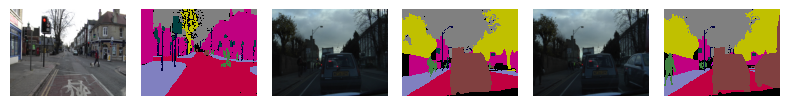

In [17]:
split = 'test'

plt.figure(figsize=(8, 4))
for i in range(3):
  x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
  plt.subplot(1, 6, i*2+1)
  imshow_image(x_batch_sample[0])
  plt.axis('off')
  plt.subplot(1, 6, i*2+2)
  imshow_label(y_batch_sample[0].to(int))
  plt.axis('off')

# note: clipping error message can be ignored
plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## UNet

In [ ]:
# Helper functions
def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def count_parameters(model, showTable=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if showTable:
        print(table)
    return total_params


def calculate_storage(model, show_buffer=True):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    if show_buffer:
        print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def stochastic_depth(input: Tensor, p: float, mode: str, training: bool = True) -> Tensor:
    """
    Implements the Stochastic Depth from `"Deep Networks with Stochastic Depth"
    <https://arxiv.org/abs/1603.09382>`_ used for randomly dropping residual
    branches of residual architectures.

    Args:
        input (Tensor[N, ...]): The input tensor or arbitrary dimensions with the first one
                    being its batch i.e. a batch with ``N`` rows.
        p (float): probability of the input to be zeroed.
        mode (str): ``"batch"`` or ``"row"``.
                    ``"batch"`` randomly zeroes the entire input, ``"row"`` zeroes
                    randomly selected rows from the batch.
        training: apply stochastic depth if is ``True``. Default: ``True``

    Returns:
        Tensor[N, ...]: The randomly zeroed tensor.
    """
    if p < 0.0 or p > 1.0:
        raise ValueError(f"drop probability has to be between 0 and 1, but got {p}")
    if mode not in ["batch", "row"]:
        raise ValueError(f"mode has to be either 'batch' or 'row', but got {mode}")
    if not training or p == 0.0:
        return input

    survival_rate = 1.0 - p
    if mode == "row":
        size = [input.shape[0]] + [1] * (input.ndim - 1)
    else:
        size = [1] * input.ndim
    noise = torch.empty(size, dtype=input.dtype, device=input.device)
    noise = noise.bernoulli_(survival_rate)
    if survival_rate > 0.0:
        noise.div_(survival_rate)
    return input * noise

class StochasticDepth(nn.Module):
    """
    See :func:`stochastic_depth`.
    """

    def __init__(self, p: float, mode: str) -> None:
        super().__init__()
        self.p = p
        self.mode = mode

    def forward(self, input: Tensor) -> Tensor:
        return stochastic_depth(input, self.p, self.mode, self.training)


    def __repr__(self) -> str:
        s = f"{self.__class__.__name__}(p={self.p}, mode={self.mode})"
        return s

### Deconv2dNormActivation

In [ ]:
class Deconv2dNormActivation(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, ...]] = 3,
        stride: Union[int, Tuple[int, ...]] = 1,
        padding: Optional[Union[int, Tuple[int, ...], str]] = None,
        out_pad: Optional[Union[int, Tuple[int, ...]]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.ReLU,
        inplace: Optional[bool] = True,
        dilation: Union[int, Tuple[int, ...]] = 1,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., nn.Module] = nn.ConvTranspose2d,
    ) -> None:
        # calculate padding
        if padding is None:
            if dilation > 1:
                padding = dilation * (kernel_size - 1) // 2
            else:
                padding = kernel_size // 2
        # calculate output padding
        if out_pad is None:
            if stride == 2:
                out_pad = 1
            else:
                out_pad = 0

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                out_pad,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))

        super().__init__(*layers)

        self.out_channels = out_channels

### MBConv
The main building block for EfficientNet, and is a superset of the inverted residual block for MobileNet. They only differ in SiLU activation function, squeeze & excitation, and stochastic depth, which can be toggled off in the configs.

In [ ]:
class MBConv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        if use_res_connect is None:
            self.use_res_connect = (
                cfg.stride == 1 and cfg.input_channels == cfg.out_channels
            )
        else:
            self.use_res_connect = use_res_connect

        layers: List[nn.Module] = []

        # expand
        expanded_channels = cfg.adjust_channels(cfg.input_channels, cfg.expand_ratio)
        if expanded_channels != cfg.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cfg.input_channels,
                    expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                expanded_channels,
                expanded_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                groups=expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )
        if se_layer is not None:
            # squeeze and excitation
            squeeze_channels = max(1, cfg.input_channels // 4)
            layers.append(
                se_layer(
                    expanded_channels,
                    squeeze_channels,
                    activation=partial(activation_layer, inplace=True),
                )
            )

        # project
        layers.append(
            Conv2dNormActivation(
                expanded_channels,
                cfg.out_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=None,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result = self.stochastic_depth(result)
            result += input
        return result

### MBConfig
The configuration dataclass used to genenerate the stages of the main building blocks of the network

In [ ]:
@dataclass
class _MBConvConfig:
    expand_ratio: float
    kernel: int
    stride: int
    input_channels: int
    out_channels: int
    num_layers: int
    dropout_p: float
    use_skip: bool # skip connection between encoder and decoder
    block: Callable[..., nn.Module]

    @staticmethod
    def adjust_channels(
        channels: int, width_mult: float, min_value: Optional[int] = None
    ) -> int:
        return _make_divisible(channels * width_mult, 8, min_value)

    @staticmethod
    def adjust_depth(num_layers: int, depth_mult: float):
        return int(math.ceil(num_layers * depth_mult))


class MBConvConfig(_MBConvConfig):
    # Stores information listed at Table 1 of the EfficientNet paper
    def __init__(
        self,
        expand_ratio: float,
        kernel: int,
        stride: int,
        input_channels: int,
        out_channels: int,
        num_layers: int,
        dropout_p: float,
        use_skip: bool,
        width_mult: float = 1.0,
        depth_mult: float = 1.0,
        block: Optional[Callable[..., nn.Module]] = MBConv,
    ) -> None:
        input_channels = self.adjust_channels(input_channels, width_mult)
        out_channels = self.adjust_channels(out_channels, width_mult)
        num_layers = self.adjust_depth(num_layers, depth_mult)
        super().__init__(
            expand_ratio,
            kernel,
            stride,
            input_channels,
            out_channels,
            num_layers,
            dropout_p,
            use_skip,
            block,
        )

### Network Config
Configuration for efficientnet and mobilenet

In [ ]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting


def _mobilenet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 3, 2, 24, 32, 3, 0, 1),
        bneck_conf(6, 3, 2, 32, 64, 4, 0, 0),
        bneck_conf(6, 3, 1, 64, 96, 3, 0.5, 1),
        bneck_conf(6, 3, 2, 96, 160, 3, 0.5, 0),
        bneck_conf(6, 3, 1, 160, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

# scaling factors and input dimensions
efficient_nets = {
    "efficientnet-b0": (1.0, 1.0, 224),
    "efficientnet-b1": (1.0, 1.1, 240),
    "efficientnet-b2": (1.1, 1.2, 260),
    "efficientnet-b3": (1.2, 1.4, 300),
    "efficientnet-b4": (1.4, 1.8, 380),
    "efficientnet-b5": (1.6, 2.2, 456),
    "efficientnet-b6": (1.8, 2.6, 528),
    "efficientnet-b7": (2.0, 3.1, 600),
}

mobile_nets = {"mobilenet-v2": (1.0, 1.0, 224)}

### unet

In [ ]:
class _Unet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[MBConvConfig],
        input_dim: Union[int, Tuple[int, int]],
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 1000,
        use_se: Optional[bool] = True,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        dropout_layer: Optional[Callable[..., nn.Module]] = nn.Dropout2d,
        last_channel: Optional[int] = None,
    ) -> None:
        super().__init__()

        self.inv_res_setting = inverted_residual_setting
        self.stochastic_depth_prob = stochastic_depth_prob
        self.num_classes = num_classes

        self.se_layer = SqueezeExcitation if use_se else None
        self.norm_layer = norm_layer
        self.activation_layer = activation_layer
        self.dropout_layer = dropout_layer
        self.input_dim = input_dim
        self.last_channel = last_channel or self.inv_res_setting[-1].out_channels * 4

        self.decoder_config = self._decoder_config()
        self.dropout_state = True
        self.stochastic_depth_state = True

        # return

        # ========= Build blocks ==========
        encoder: OrderedDict = self._build_encoder()
        decoder: OrderedDict = self._build_decoder()
        self.encoder = nn.Sequential(encoder)
        self.decoder = nn.Sequential(decoder)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # ========= weight initialization ========
        self._init_weights()

    def forward(self, x: Tensor) -> Tensor:
        """
        Returns logits
        """
        self._toggle_stochastic_depth()
        self._toggle_dropout()
        return self._forward_impl(x)

    def _forward_impl(self, x: Tensor) -> Tensor:
        features = []
        # ================= Encoder =================
        # first conv
        x = self.encoder.conv0(x)
        # stages
        for i, cfg in enumerate(self.inv_res_setting):
            x = self.encoder[i + 1](x)
            if cfg.use_skip:
                features.append(x)
        # last conv
        x = self.encoder.lastConv(x)

        # ================= Decoder =================
        # first deconv
        x = self.decoder.deconv0(x)
        # stages
        for i, cfg in enumerate(self.decoder_config):
            x = self.decoder[i + 1](x)
            if i < len(self.decoder_config) - 1 and self.decoder_config[i + 1].use_skip:
                x = torch.cat([x, features.pop()], dim=1)
        # last deconv
        x = self.decoder.lastDeconv(x)
        x = self.logsoftmax(x)

        return x

    def _decoder_config(self) -> List[MBConvConfig]:
        decoder_cfg: List[MBConvConfig] = []
        oup = self.inv_res_setting[0].input_channels
        skip = 0
        for cfg in self.inv_res_setting:
            skip = cfg.out_channels if cfg.use_skip else 0
            cfg_copy = copy.copy(cfg)
            cfg_copy.input_channels = cfg.out_channels + skip
            cfg_copy.out_channels = oup
            decoder_cfg.append(cfg_copy)

            oup = cfg.out_channels

        return decoder_cfg[::-1]

    def _build_decoder(self) -> OrderedDict:
        decoder: OrderedDict[str, nn.Module] = OrderedDict()

        out = self.inv_res_setting[-1].out_channels
        decoder["deconv0"] = Conv2dNormActivation(
            self.last_channel, out, 1, 1, bias=False
        )

        def compute_out_pad(stage: int, dim: int) -> int:
            dim = math.ceil(dim / 2)  # account for first encoder
            # reverse the order to calculate output dim for corresponding encoder
            stage = len(self.inv_res_setting) - stage - 1
            for cfg in self.inv_res_setting[:stage]:
                if cfg.stride != 1:
                    # reduce dim if stride is not 1
                    dim = math.ceil(dim / 2)
            return int(dim % 2 == 0)

        # build inverted residual blocks
        total_stage_blocks = sum(cfg.num_layers for cfg in self.inv_res_setting)
        stage_block_id = 0
        for i, cfg in enumerate(self.decoder_config):
            stage: List[nn.Module] = []
            for j in range(cfg.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cfg = copy.copy(cfg)

                conv_layer = Conv2dNormActivation
                if block_cfg.stride != 1 and j == 0:
                    if isinstance(self.input_dim, tuple):
                        dim1, dim2 = self.input_dim
                        oup_pad = compute_out_pad(i, dim1), compute_out_pad(i, dim2)
                    else:
                        oup_pad = compute_out_pad(i, self.input_dim)
                    conv_layer = partial(
                        Deconv2dNormActivation,
                        out_pad=oup_pad,
                    )

                # adjust stochastic depth probability
                sd_prob = self.stochastic_depth_prob * (
                    1 - float(stage_block_id) / total_stage_blocks
                )

                # overwrite cfg if not first conv in the stage
                if j != 0:
                    block_cfg.input_channels = block_cfg.out_channels
                    block_cfg.stride = 1
                    sd_prob = 0

                stage.append(
                    block_cfg.block(
                        block_cfg,
                        sd_prob,
                        self.norm_layer,
                        self.se_layer,
                        conv_layer,
                        self.activation_layer,
                    )
                )
                stage_block_id += 1

            if cfg.dropout_p > 0:
                stage.append(self.dropout_layer(cfg.dropout_p))

            decoder[f"stage{i+1}"] = nn.Sequential(*stage)

        # build last deconv
        decoder["lastDeconv"] = Deconv2dNormActivation(
            self.decoder_config[-1].out_channels,
            self.num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            norm_layer=self.norm_layer,
            activation_layer=self.activation_layer,
        )
        return decoder

    def _build_encoder(self) -> OrderedDict:
        encoder: OrderedDict[str, nn.Module] = OrderedDict()

        # build first conv layer
        firstconv_output_channels = self.inv_res_setting[0].input_channels
        encoder["conv0"] = Conv2dNormActivation(
            3,
            firstconv_output_channels,
            kernel_size=3,
            stride=2,
            norm_layer=self.norm_layer,
            activation_layer=self.activation_layer,
        )

        # build inverted residual blocks
        total_stage_blocks = sum(cfg.num_layers for cfg in self.inv_res_setting)
        stage_block_id = 0
        for i, cfg in enumerate(self.inv_res_setting):
            stage: List[nn.Module] = []
            for j in range(cfg.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cfg = copy.copy(cfg)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cfg.input_channels = block_cfg.out_channels
                    block_cfg.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = (
                    self.stochastic_depth_prob
                    * float(stage_block_id)
                    / total_stage_blocks
                )

                stage.append(
                    block_cfg.block(
                        block_cfg,
                        sd_prob,
                        self.norm_layer,
                        self.se_layer,
                        Conv2dNormActivation,
                        activation_layer=self.activation_layer,
                    )
                )
                stage_block_id += 1

            if cfg.dropout_p > 0:
                stage.append(self.dropout_layer(cfg.dropout_p))

            encoder[f"stage{i+1}"] = nn.Sequential(*stage)

        # build last several layers
        lastconv_input_channels = self.inv_res_setting[-1].out_channels
        lastconv_output_channels = self.last_channel
        encoder["lastConv"] = Conv2dNormActivation(
            lastconv_input_channels,
            lastconv_output_channels,
            kernel_size=1,
            norm_layer=self.norm_layer,
            activation_layer=nn.SiLU,
        )

        encoder["lastConv"] = nn.Sequential(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=self.norm_layer,
                activation_layer=self.activation_layer,
            ),
            nn.Dropout2d(p=self.inv_res_setting[-1].dropout_p),
        )
        return encoder

    def _init_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _toggle_dropout(self) -> None:
        if self.dropout_state == True:
            for m in self.modules():
                if m.__class__.__name__.startswith("Dropout"):
                    m.train()

    def _toggle_stochastic_depth(self) -> None:
        if self.stochastic_depth_state == True:
            for m in self.modules():
                if m.__class__.__name__.startswith("StochasticDepth"):
                    m.train()

    def _set_dropout(self, state: bool) -> None:
        self.dropout_state = state

    def _set_stochastic_depth(self, state: bool) -> None:
        self.stochastic_depth_state = state

    def set_bayes_mode(self, state: bool, mode: str) -> None:
        if mode == "dropout":
            self._set_dropout(state)
        elif mode == "stochastic_depth":
            self._set_stochastic_depth(state)
        elif mode == "all":
            self._set_dropout(state)
            self._set_stochastic_depth(state)
        else:
            raise ValueError(
                f"mode must be dropout, stochastic_depth, or all, got {mode}"
            )


class Unet(_Unet):
    def __init__(
        self,
        encoder_name: str = "efficientnet-b0",
        input_dim: Optional[Union[int, Tuple[int, int]]] = None,
        stochastic_depth_prob: float = 0.2,
        dropout_p: float = 0.5,
        num_classes: int = 3,
        last_channel: Optional[int] = None,
        constant_dropout: Optional[bool] = True,
    ):
        if encoder_name.startswith("efficientnet"):
            width_mult = efficient_nets[encoder_name][0]
            depth_mult = efficient_nets[encoder_name][1]
            d = efficient_nets[encoder_name][2] if not input_dim else input_dim
            use_se = True
            activation_layer = nn.SiLU
            cfg = _efficientnet_cfg(width_mult, depth_mult)
        elif encoder_name.startswith("mobilenet"):
            width_mult = mobile_nets[encoder_name][0]
            depth_mult = mobile_nets[encoder_name][1]
            d = mobile_nets[encoder_name][2] if not input_dim else input_dim
            use_se = False
            activation_layer = nn.ReLU
            stochastic_depth_prob = 0.0
            cfg = _mobilenet_cfg(width_mult, depth_mult)
        else:
            raise NotImplementedError

        for i in range(len(cfg)):
            if constant_dropout:
                cfg[i].dropout_p = dropout_p if cfg[i].dropout_p > 0 else 0
            else:
                # linearly interpolate the dropout rate
                cfg[i].dropout_p = dropout_p * float(i) / (len(cfg) - 1)

        super().__init__(
            cfg,
            d,
            stochastic_depth_prob,
            num_classes,
            last_channel=last_channel,
            use_se=use_se,
            activation_layer=activation_layer,
        )

## network definition

In [ ]:
net_name = "mobilenet-v2"
# net_name = "efficientnet-b0"

net = Unet(net_name, input_dim=(HEIGHT, WIDTH),dropout_p=0.5, constant_dropout=False, stochastic_depth_prob=0.2, num_classes=NUM_CLASSES)

print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params/1e6 :.3f}M")

net.to(DEVICE)
print(f'moved network to {DEVICE}')

----UNET----
Buffer size: 0.262 MB
model size: 18.072MB
Total Trainable Params: 4.669M
moved network to cuda:0


### Dummy pass to see initial outputs

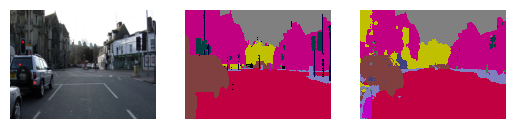

In [ ]:
x_batch_sample, y_batch_sample = next(iter(val_dataloader))

# net = net
net = training_manager.net

with torch.no_grad():
  net.eval()
  net.set_bayes_mode(False, 'all')
  plt.subplot(1, 3, 1)
  plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(1, 3, 2)
  imshow_label(y_batch_sample[0])
  plt.axis('off')
  net.train()

  pred = net(x_batch_sample.to(DEVICE))
  plt.subplot(1, 3, 3)
  imshow_label(torch.argmax(pred[0], dim=0))
  plt.axis('off')
  net.train()

In [ ]:
y_batch_sample[0][0][100]

tensor([9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
        7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 5., 7., 7., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 

In [ ]:
torch.argmax(pred[0], dim=0)[100]

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 7, 7, 7, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
del(net)

## Loss

In [ ]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / (mask.sum()+1e-16)

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [ ]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [ ]:
class AccuracyMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [ ]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

# Bayesian Functions

## Bayes forward pass

In [ ]:
def bayes_forward(net, X:torch.tensor, k:int, buffer=None):
  '''
  Performs k forward passes with dropout layers, returns mean and std

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x c x 224 x 224) buffer

  Returns
  -----------
  y_softmax            : torch.tensor (c x 224 x 224)
  y_pred               : torch.tensor (224 x 224)
  y_pred_std_per_class : torch.tensor (c x 224 x 224)
  y_pred_std_avg       : torch.tensor (224 x 224)
  '''
  if buffer is None:
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
  else:
    for i in range(k):
      # write image to buffer
      buffer[i] = X

  with torch.no_grad():
      net.eval()
      net.set_bayes_mode(True, 'all')
      y_pred_raw = net(buffer)

  net.train()

  # Average the softmax (note that the resultant vectors are not normalised)
  y_softmax = y_pred_raw.mean(dim=0) # (c x 224 x 224)
  # Take max prob as prediction
  y_pred = torch.argmax(y_softmax, dim=0).to(torch.int) # (224 x 224)
  # Per class uncertainty
  y_pred_std_per_class = y_pred_raw.var(dim=0) # (c x 224 x 224)
  # Average uncertainty over classes
  y_pred_std_avg = y_pred_std_per_class.mean(dim=0) # (224 x 224)

  return y_softmax, y_pred, y_pred_std_per_class, y_pred_std_avg

In [ ]:
# net = training_manager.net
# x_batch_sample, y_batch_sample = next(iter(val_dataloader))

In [ ]:
# with torch.no_grad():
#   net.eval()
#   net.set_bayes_mode(False, 'stochastic_depth')
#   net.set_bayes_mode(True, 'dropout')
#   plt.subplot(1, 2, 1)
#   plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
#   plt.axis('off')

#   pred = net(x_batch_sample.to(DEVICE))
#   plt.subplot(1, 2, 2)
#   plt.imshow(torch.argmax(pred[0], dim=0).cpu().detach().numpy())
#   plt.axis('off')
#   net.train()

## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

In [ ]:
def bayes_eval(net, X:torch.tensor, k:int, buffer=None):
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x c x 224 x 224) buffer

  Returns
  -----------
  y_pred               : torch.tensor (224 x 224)
  '''

  with torch.no_grad():
    net.eval()
    if k == 0:
      net.set_bayes_mode(False, 'all')
      y_pred_raw = net(X)
    elif k > 0:
      net.set_bayes_mode(True, 'all')
      # write image to buffer
      if buffer is None:
        buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
      else:
        for i in range(k):
          buffer[i] = X
      y_pred_raw = net(buffer)
      # y_pred_raw = torch.rand((k, c, 224, 224))

  y_pred = torch.argmax(y_pred_raw.mean(dim=0), dim=0).to(torch.int8) # (224 x 224)

  return y_pred

## Calibration

In [ ]:
def plot_calibration(net, dataloader, ks=[0, 5, 10], num_buckets = 10):
  x_axis = np.array(range(num_buckets)) / num_buckets
  linear_line = np.array(range(num_buckets+1)) / (num_buckets+1)

  plt.figure(figsize=(8, 6))
  plt.plot(linear_line, linear_line, color='black', zorder=2)
  for i, k in enumerate(ks):
    buckets = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)
    # plt.subplot(1, 3, i+1)
    # plt.bar(x_axis, buckets, width=0.5, align='edge')
    plt.plot(x_axis, buckets, label=f'k={k}')
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  plt.legend()


def get_calibration(net, dataloader, k:int, num_buckets=10):
  '''
  Plots reliability graph for the network

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  '''
  total_counts = np.array([1e-16]*num_buckets)
  total_corrects = np.array([0]*num_buckets)

  # loop through images and make predictions
  for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, 'all')
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        # y_softmax = y_softmax

        counts, corrects =  get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects
      #   count += 1
      # if count == 10:
      #   break

  buckets = total_corrects / total_counts

  return buckets

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x 224 x 224)
  y_softmax: torch.tensor (c x 224 x 224)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, )
  correct: np.array (num_buckets, )
  '''
  out_count = np.array([0]*num_buckets)
  out_correct = np.array([0]*num_buckets)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    out_count[i] += ((indices==i)).sum()
    out_correct[i] += ((indices==i)*(y_pred==y_gt)).sum()

  return out_count, out_correct


## Epistemic & Aleatoric Uncertainties

In [ ]:
def compute_bayesian_uncertainties(net, X:Tensor, k:int,) -> (Tensor, Tensor):
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x c x 224 x 224) buffer

  Returns
  -----------
  aleatoric_uncertainty: torch.tensor (224 x 224)
  epistemic_uncertainty: torch.tensor (224 x 224)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, 'all')
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X
    y_pred_raw = net(buffer)

    avg_over_k = y_pred_raw.mean(dim=0)
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k)).sum(dim=0)
    mutual_information = predictive_entropy + 1/k * (y_pred_raw*torch.log(y_pred_raw)).sum(dim=0).sum(dim=0)

  epistemic_uncertainty = mutual_information
  aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

  return aleatoric_uncertainty, epistemic_uncertainty

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [ ]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.patience = self.config.get('patience', 20)
    self.num_classes = self.config.get('num_classes', 3)
    self.bayes_mode = self.config.get('bayes_mode', 'all')
    self.eval_subset = self.config.get('eval_subset', None)

    # initiate dataloader
    train_dataloader = DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True)
    val_dataloader = DataLoader(self.datasets['val'], batch_size=1, shuffle=True)
    test_dataloader = DataLoader(self.datasets['test'], batch_size=1, shuffle=False)
    self.dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

    # initiate net

    self.net = Unet(self.config['model'],
                    self.config['input_dim'],
                    self.config['stochastic_depth_prob'],
                    self.config['dropout_p'],
                    self.num_classes,
                    constant_dropout = self.config['dropout_mode'] == 'constant')
    self.net.to(DEVICE)
    self.best_net = None

    # dropout parameters
    # self.net.set_bayes_mode(True, self.bayes_mode)
    # self.net.update_dropout_config(encoder_dropout_config, decoder_dropout_config)

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.epoch = 0
    self.early_stop = False
    self.history = {
        'loss/train': [],
        'loss/val': [],
        'loss/val_b': [],
        # 'loss/test': [],
        'acc/avg/train': [],
        'acc/avg/val': [],
        'acc/avg/val_b': [],
        # 'acc/avg/test': [],
        'acc/global/train': [],
        'acc/global/val': [],
        'acc/global/val_b': [],
        'iou/mean/train': [],
        'iou/mean/val': [],
        'iou/mean/val_b': [],
        'lr': [],
        # 'acc/global/test': [],
    }

    for c in CLASS_MAP.values():
      self.history[f'acc/{c}/val'] = []
      self.history[f'acc/{c}/val_b'] = []
      self.history[f'iou/{c}/val'] = []
      self.history[f'iou/{c}/val_b'] = []
      # self.history[f'acc/{c}/test'] = []

    self.history['best_val_loss'] = 999
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    # torch.cuda.empty_cache() # helps clearing RAM
    # self.net.train()
    # self.net.set_bayes_mode(True, net.set_bayes_mode)

    for e in range(epochs):
      self.net.train()
      self.net.set_bayes_mode(True, self.bayes_mode)
      train_loss_epoch = 0
      train_global_acc_epoch = 0
      train_avg_acc_epoch = 0
      train_mIOU_epoch = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_pred = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_pred)
        accs = self.metric(y_batch, y_pred)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_loss_epoch += loss * batch_size
        train_global_acc_epoch += accs['acc/global'] * batch_size
        train_avg_acc_epoch += accs['acc/avg'] * batch_size
        train_mIOU_epoch += accs['iou/mean'] * batch_size

      # log epoch loss and accuracy
      n_train = len(self.dataloaders['train'].dataset)
      self.history['loss/train'].append(train_loss_epoch.item()/n_train)
      self.history['acc/global/train'].append(train_global_acc_epoch.item()/n_train)
      self.history['acc/avg/train'].append(train_avg_acc_epoch.item()/n_train)
      self.history['iou/mean/train'].append(train_mIOU_epoch.item()/n_train)

      # run network on validation set
      # if self.epoch+1 % 5 == 0:
      #   val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=None)
      # else:
      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=self.eval_subset)

      self._update_best_net()
      if self.early_stop:
        return

      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self.history['lr'].append(self._lr)
      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

  def _lr(self)->float:
    return self.optimizer.param_groups[0]['lr']

  def _set_lr(self, lr:float)->None:
    self.optimizer.param_groups[0]['lr'] = lr

  def _update_best_net(self, min_epochs=10):
    metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history[metric]) <= 1:
      return

    loss = self.history[metric][-1]
    curr_min = self.history['best_val_loss']

    if loss < curr_min:
      print(f'updating best net, loss decreased by {(curr_min-loss)/curr_min*100 :.3f} %')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_val_loss'] = loss
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0
    else:
      self.patience_count += 1
    if self.patience_count >= self.patience:
      if self._lr != 1e-5:
        self._set_lr(self._lr/10)
        print(f'Decrease lr to {self._lr}')
      else:
        print(f'{metric} has not improved for {self.patience} epochs, terminate training')
        self.early_stop = True

  def _evaluate_regular(self, dataloader, net=None):
    net = net if net != None else self.net
    net.eval()
    net.set_bayes_mode(False, 'all')
    total_loss = 0
    total_accs = {}
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)
        total_loss += loss * len(X)

        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc * len(X)

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    buffer_tensor = torch.empty(size=(k, 3, HEIGHT, WIDTH), dtype=torch.float32, device=DEVICE)

    # net.toggle_dropout(True)
    # net.update_dropout_config(self.encoder_dropout_config,
    #                                self.decoder_dropout_config)

    total_loss = 0
    total_accs = {}
    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_pred, _, _, _ = bayes_forward(net, x, k, buffer_tensor)
        y_pred = y_pred.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)

        total_loss += loss
        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def evaluate(self, eval_dataset='val', mode='bayes', subset=None):
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    if not subset:
      dataloader = self.dataloaders[eval_dataset]
    else:
      indices = torch.randperm(len(self.datasets[eval_dataset]))[:subset]
      sub_eval_dataset = torch.utils.data.Subset(self.datasets[eval_dataset], indices)
      dataloader = DataLoader(sub_eval_dataset, batch_size=1, shuffle=True)

    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(dataloader)
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(dataloader)
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(dataloader)
      loss_b, accs_b = self._evaluate_bayes(dataloader)
    else:
      return

    return loss, accs, loss_b, accs_b

  def plot(self, save=False, directory=None):
    '''
    Plots training history
    '''
    plt.figure(figsize=(16, 16))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.epoch+1, 1))
    plt.subplot(3, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(3, 3, 2)
    plt.title('Accuracy(g)')
    plt.plot(x, history['acc/global/train'], label='train',)
    plt.plot(x, history['acc/global/val'], label='val')
    plt.plot(x, history['acc/global/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    # plt.subplot(3, 3, 3)
    # plt.title('Accuracy(c)')
    # plt.plot(x, history['acc/avg/train'], label='train',)
    # plt.plot(x, history['acc/avg/val'], label='val')
    # plt.plot(x, history['acc/avg/val_b'], label='val_b')
    # plt.xlabel('epochs')
    # plt.ylabel('acc')
    # plt.legend()

    plt.subplot(3, 3, 3)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('iou')
    plt.legend()

    for i in range(3):
      plt.subplot(3, 3, 4+i)
      c_name = CLASS_MAP[i]
      plt.title(f'Accuracy({c_name})')
      # plt.plot(x, history[f'acc/{c_name}/train'], label='train',)
      plt.plot(x, history[f'acc/{c_name}/val'], label='val')
      plt.plot(x, history[f'acc/{c_name}/val_b'], label='val_b')
      plt.xlabel('epochs')
      plt.ylabel('acc')
      plt.legend()

    for i in range(3):
      plt.subplot(3, 3, 7+i)
      c_name = CLASS_MAP[i]
      plt.title(f'IOU({c_name})')
      plt.plot(x, history[f'iou/{c_name}/val'], label='val')
      plt.plot(x, history[f'iou/{c_name}/val_b'], label='val_b')
      plt.xlabel('epochs')
      plt.ylabel('iou')
      plt.legend()

    if save:
      plt.savefig(os.path.join(directory, 'history.png'), dpi=200)
    else:
      plt.show()

    return

  def plot_acc_vs_k(self, ks=[1, 3, 5, 10, 15, 20, 25, 30, 35, 40], dataloader=None, num_repeats=5, save_to_dir=None, net=None):
    '''
    plots accuracy vs k
    '''
    if dataloader is None:
      dataloader = self.dataloaders['val']

    # evaluate bayesian forward for different ks
    losses, accs_g, accs_a, mious = [], [], [], []
    losses_std, accs_g_std, accs_a_std, mious_std = [], [], [], []
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self._evaluate_regular(dataloader, net)

    for k in tqdm(ks):
      loss, acc_g, acc_a, miou = [], [], [], []
      for i in range(num_repeats):
        l, a = self._evaluate_bayes(dataloader, k, net)
        loss.append(l)
        acc_g.append(a['acc/global'])
        acc_a.append(a['acc/avg'])
        miou.append(a['iou/mean'])
      loss, acc_g, acc_a, miou = np.array(loss), np.array(acc_g), np.array(acc_a), np.array(miou)
      losses.append(loss.mean())
      losses_std.append(loss.std())
      accs_g.append(acc_g.mean())
      accs_g_std.append(acc_g.std())
      accs_a.append(acc_a.mean())
      accs_a_std.append(acc_a.std())
      mious.append(miou.mean())
      mious_std.append(miou.std())

      # print(f'{k}: {loss}, {accs['global']}, {accs['avg']}')


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, losses, yerr=losses_std, label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, accs_g, yerr=accs_g_std, label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, accs_a, yerr=accs_a_std, label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, mious, yerr=mious_std, label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    if save_to_dir != None:
      plt.savefig(os.path.join(save_to_dir, 'acc_v_k.png'), dpi=200)

    return

  def _save_model(self, directory, save_best):
    print(f'saving model at {self.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.net.state_dict(), os.path.join(directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.best_net != None:
      torch.save(self.best_net.state_dict(), os.path.join(directory, 'model_best.pt'))
    return

  def _save_history(self, directory):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    history['date'] = str(date.today())
    history['epoch'] = self.epoch
    filepath = os.path.join(directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f)
    return

  def _save_config(self, directory):
    print('saving config...')
    filepath = os.path.join(directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f)
    return

  def _save_summary(self, directory):
    print('saving summary...')
    summary_json = {'WA': {}, 'Bayes': {}}
    l, a, l_b, a_b = self.evaluate(mode='all')
    summary_json['WA']['loss'] = l
    summary_json['Bayes']['loss'] = l_b
    summary_json['WA']['metrics'] = a
    summary_json['WA']['metrics'] = a_b
    filepath = os.path.join(directory, 'summary.json')
    with open(filepath, "w") as f:
      json.dump(summary_json, f)
    return


  def save(self, directory, save_best=True, save_plot=False):
    # save model
    self._save_model(directory, save_best)

    # save config.json
    self._save_config(directory)

    # save history.json
    self._save_history(directory)

    if save_plot:
      print('saving png...')
      self.plot(save=True, directory=directory)

    print(f'Finished saving everything to {directory}.')

    return

  def load(self, directory, load_best=False):
    print('Loading config...')
    config_path = os.path.join(directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    self._load()

    print('Loading network weights...')
    # load network
    if load_best:
      ckpt_path = os.path.join(directory, 'model_best.pt')
    else:
      ckpt_path = os.path.join(directory, 'model.pt')
    ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
    self.net.load_state_dict(ckpt)

    print('Loading history...')
    history_path = os.path.join(directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded {ckpt_path} trained for {self.epoch} epochs')
    return


# Experiments Section

In [ ]:
def create_experiment_dir(config: dict) -> None:
  dataset = config.get("dataset", 'camvid')
  RESULT_DIR = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{dataset}/'
  EXPERIMENT = config['experiment']

  EXPERIMENT_DIR = os.path.join(RESULT_DIR, EXPERIMENT)

  if EXPERIMENT not in os.listdir(RESULT_DIR):
    os.mkdir(EXPERIMENT_DIR)
  else:
    num_items = len(os.listdir(EXPERIMENT_DIR))
    if num_items > 0:
      print('warning: duplicate experimentf name!')
      print(f'directory at {EXPERIMENT_DIR} already exists and contains {num_items} items')

  return EXPERIMENT_DIR

In [ ]:
torch.cuda.empty_cache()

config = {
    'experiment': 'mobileNet(test)',
    'dataset': 'camvid',
    'num_classes': NUM_CLASSES,
    'model': 'mobilenet-v2',
    'input_dim': (HEIGHT, WIDTH),
    'loss': 'CE',
    'lr': 1e-3,
    'batch_size': 10,
    'weight_decay': 1e-5,
    'dropout_p': 0.3,
    'dropout_mode': 'linear',
    'stochastic_depth_prob': 0,
    'k': 5,
    'eval_subset': None,
    'patience': 100,
}

EXPERIMENT_DIR = create_experiment_dir(config)

training_manager = TrainingManager(dataset_manager.datasets, config)

In [ ]:
training_manager.evaluate('test', mode='all', subset=None)

In [ ]:
training_manager.train(epochs=20, eval_mode='regular')

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 51
Train: Acc(g) = 90.8244, Acc(c) = 64.5430, mIOU = 60.5821, Loss = 0.3116
Val: Acc(g) = 92.0812, Acc(c) = 54.2025, mIOU = 51.1495, Loss = 0.2674


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 10.048 %
Epoch 52
Train: Acc(g) = 91.1422, Acc(c) = 65.0410, mIOU = 61.0194, Loss = 0.3025
Val: Acc(g) = 92.2349, Acc(c) = 54.5142, mIOU = 51.4696, Loss = 0.2628


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 1.733 %
Epoch 53
Train: Acc(g) = 91.2329, Acc(c) = 65.4997, mIOU = 61.3997, Loss = 0.2984
Val: Acc(g) = 92.2973, Acc(c) = 54.7958, mIOU = 51.6229, Loss = 0.2606


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 0.846 %
Epoch 54
Train: Acc(g) = 91.4908, Acc(c) = 66.2934, mIOU = 62.1359, Loss = 0.2916
Val: Acc(g) = 92.3167, Acc(c) = 54.8786, mIOU = 51.7436, Loss = 0.2594


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 0.435 %
Epoch 55
Train: Acc(g) = 91.3531, Acc(c) = 65.8849, mIOU = 61.8755, Loss = 0.2936
Val: Acc(g) = 92.4563, Acc(c) = 54.6652, mIOU = 51.7141, Loss = 0.2560


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 1.333 %
Epoch 56
Train: Acc(g) = 91.4187, Acc(c) = 65.7215, mIOU = 61.5364, Loss = 0.2939
Val: Acc(g) = 92.4235, Acc(c) = 54.9884, mIOU = 51.8558, Loss = 0.2545


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 0.561 %
Epoch 57
Train: Acc(g) = 91.6086, Acc(c) = 66.1842, mIOU = 62.1912, Loss = 0.2866
Val: Acc(g) = 92.3429, Acc(c) = 54.7770, mIOU = 51.7565, Loss = 0.2591


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 58
Train: Acc(g) = 91.5727, Acc(c) = 66.0684, mIOU = 62.1336, Loss = 0.2875
Val: Acc(g) = 92.4498, Acc(c) = 54.8525, mIOU = 51.8647, Loss = 0.2553


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 59
Train: Acc(g) = 91.4969, Acc(c) = 66.2233, mIOU = 62.2776, Loss = 0.2879
Val: Acc(g) = 92.4806, Acc(c) = 54.9218, mIOU = 51.9324, Loss = 0.2535


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 0.393 %
Epoch 60
Train: Acc(g) = 91.6922, Acc(c) = 67.0565, mIOU = 62.9347, Loss = 0.2842
Val: Acc(g) = 92.5413, Acc(c) = 55.3249, mIOU = 52.1741, Loss = 0.2521


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 0.569 %
Epoch 61
Train: Acc(g) = 91.6880, Acc(c) = 66.7331, mIOU = 62.7938, Loss = 0.2838
Val: Acc(g) = 92.6101, Acc(c) = 55.5028, mIOU = 52.3903, Loss = 0.2490


  0%|          | 0/37 [00:00<?, ?it/s]

updating best net, loss decreased by 1.243 %
Epoch 62
Train: Acc(g) = 91.5993, Acc(c) = 66.0990, mIOU = 62.1813, Loss = 0.2858
Val: Acc(g) = 92.5165, Acc(c) = 55.3452, mIOU = 52.2447, Loss = 0.2536


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 63
Train: Acc(g) = 91.5629, Acc(c) = 66.2674, mIOU = 62.1941, Loss = 0.2877
Val: Acc(g) = 92.4133, Acc(c) = 55.3889, mIOU = 52.1032, Loss = 0.2569


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 64
Train: Acc(g) = 91.8311, Acc(c) = 67.0199, mIOU = 63.0230, Loss = 0.2795
Val: Acc(g) = 92.4751, Acc(c) = 55.1089, mIOU = 52.0980, Loss = 0.2540


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 65
Train: Acc(g) = 91.5904, Acc(c) = 66.2108, mIOU = 62.2521, Loss = 0.2853
Val: Acc(g) = 92.5027, Acc(c) = 55.1482, mIOU = 52.0898, Loss = 0.2529


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 66
Train: Acc(g) = 91.7485, Acc(c) = 66.7652, mIOU = 62.7931, Loss = 0.2812
Val: Acc(g) = 92.5235, Acc(c) = 55.2612, mIOU = 52.2306, Loss = 0.2527


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 67
Train: Acc(g) = 91.6856, Acc(c) = 66.5517, mIOU = 62.4540, Loss = 0.2836
Val: Acc(g) = 92.5469, Acc(c) = 55.6456, mIOU = 52.5166, Loss = 0.2519


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 68
Train: Acc(g) = 91.7357, Acc(c) = 66.4308, mIOU = 62.5444, Loss = 0.2812
Val: Acc(g) = 92.4728, Acc(c) = 55.3998, mIOU = 52.2755, Loss = 0.2532


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 69
Train: Acc(g) = 91.4673, Acc(c) = 66.8375, mIOU = 62.6370, Loss = 0.2879
Val: Acc(g) = 92.5657, Acc(c) = 55.1649, mIOU = 52.2161, Loss = 0.2501


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 70
Train: Acc(g) = 91.8408, Acc(c) = 66.9149, mIOU = 62.8852, Loss = 0.2795
Val: Acc(g) = 92.5709, Acc(c) = 55.6168, mIOU = 52.4641, Loss = 0.2503


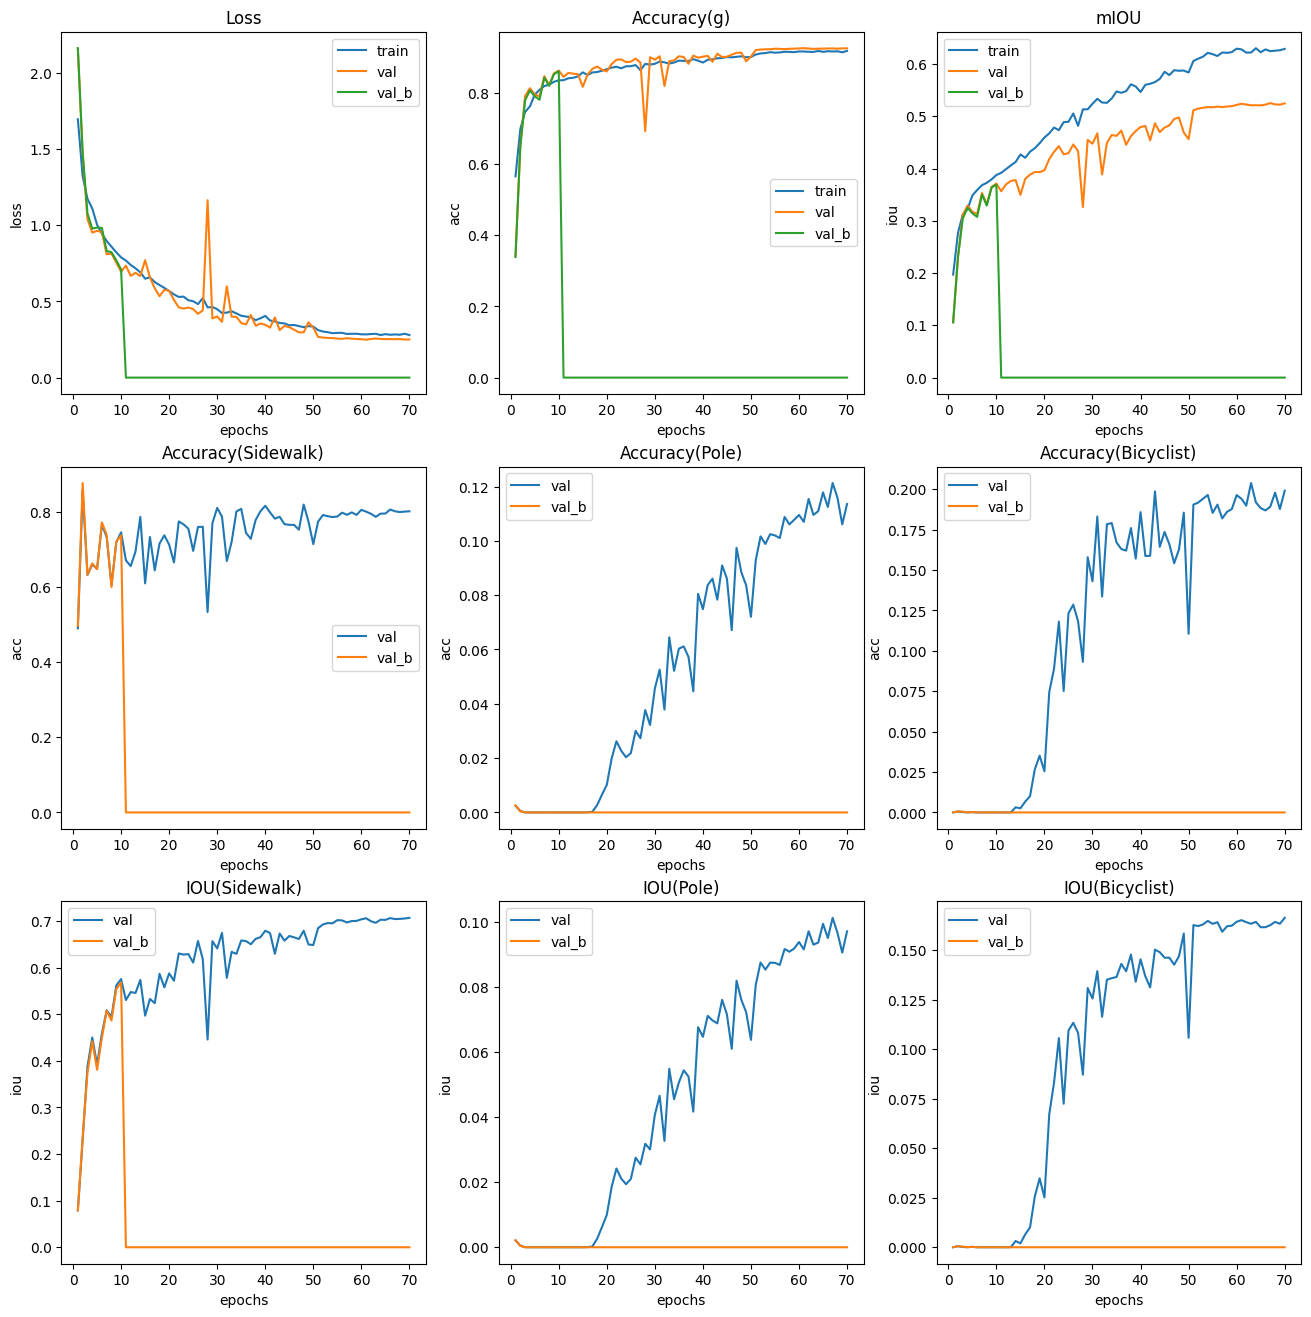

In [ ]:
training_manager.plot()

In [ ]:
training_manager.save(EXPERIMENT_DIR, save_plot=True)

saving model at 70 epochs...
saving best model at 61 epochs...
saving config...
saving history...


TypeError: ignored

## Qualitative performance

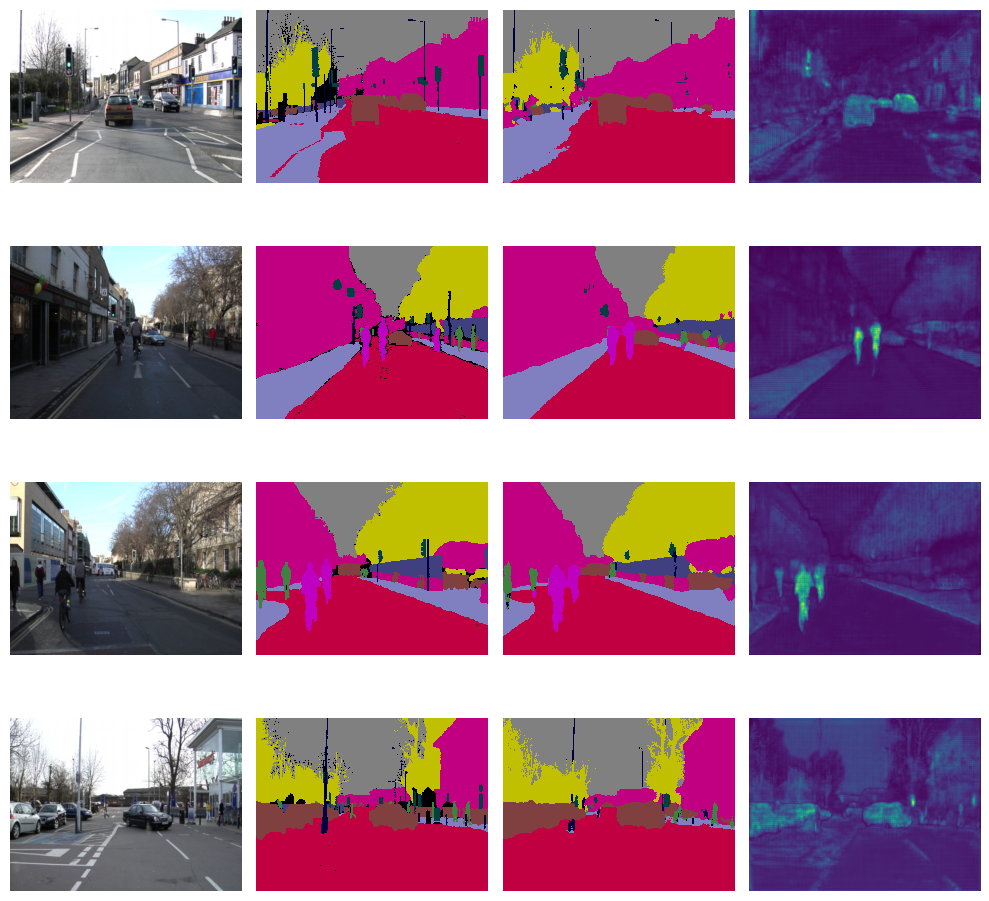

In [ ]:
exp = training_manager
plt.figure(figsize=(10, 10))

k = 10

with torch.no_grad():
  for i in range(4):
    x, y = next(iter(dataloaders['val']))
    x, y = x[0], y[0]
    y_softmax, y_pred, _, y_std = bayes_forward(exp.net, x, k)
    # y_pred = bayes_eval(exp.net, x.unsqueeze(0), k)
    plt.subplot(4, 4, i*4+1)
    imshow_image(x)
    plt.axis('off')

    plt.subplot(4, 4, i*4+2)
    imshow_label(y)
    plt.axis('off')

    plt.subplot(4, 4, i*4+3)
    imshow_label(y_pred)
    plt.axis('off')

    plt.subplot(4, 4, i*4+4)
    plt.imshow(y_std.cpu())
    plt.axis('off')

  plt.tight_layout()

plt.savefig(os.path.join(EXPERIMENT_DIR, 'qualitative.png'), dpi=200)
# print(f"saved to {os.path.join(EXPERIMENT_DIR, 'qualitative.png')}")